# Introduction
A sentiment analysis job about the problems of each major U.S. airline. [Twitter data](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service")

# Importing modules

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

import gensim

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)

# Loading the data
We shuffle the data frame in case the classes would be sorted. This can be done with the **reindex** method applied on the **permutation** of the original indices. In this notebook we will only focus on the text variable and the class variable.

In [2]:
df = pd.read_csv('C:/Users/1/Python/NLP/Twitter_airline_sentiment/Tweets.csv', nrows = 1000)
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]

# Exploratory Data Analysis

## Target variable
There are three class labels to predict: *negative, neutral or positive*. 

**CONCLUSION: **The class labels are **imbalanced** as we can see below. This is something that we should keep in mind during the model training phase. We could, for instance, make sure the classes are balanced by up/undersampling.

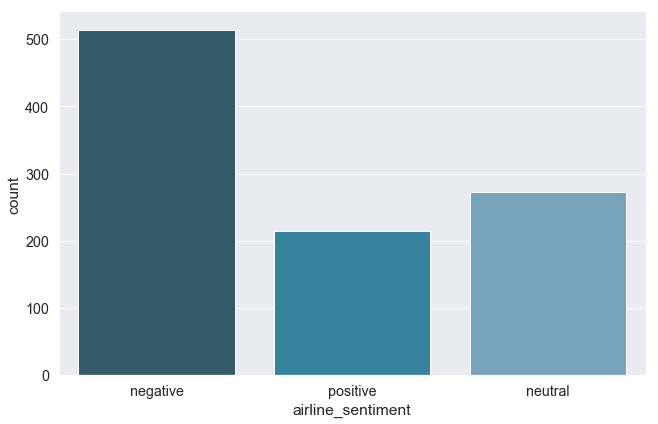

In [3]:
sns.factorplot(x="airline_sentiment", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

## Text variable
To analyze the text variable we create a class **TextCounts**. In this class we compute some basic statistics on the text variable. This class can be used later in a Pipeline, as well.

* **count_words** : number of words in the tweet
* **count_mentions** : referrals to other Twitter accounts, which are preceded by a @
* **count_hashtags** : number of tag words, preceded by a #
* **count_capital_words** : number of uppercase words, could be used to *"shout"* and express (negative) emotions
* **count_excl_quest_marks** : number of question or exclamation marks
* **count_urls** : number of links in the tweet, preceded by http(s)
* **count_emojis** : number of emoji, which might be a good indication of the sentiment

In [11]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [12]:
tc = TextCounts()
df_eda = tc.fit_transform(df.text)

It could be interesting to see how the TextStats variables relate to the class variable. Therefore we write a function **show_dist** that provides descriptive statistics and a plot per target class.

In [13]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='airline_sentiment', size=5, hue='airline_sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

In [14]:
# Add airline_sentiment to df_eda
df_eda['airline_sentiment'] = df.airline_sentiment

Descriptive stats for count_words
---------------------------------
                   count       mean       std  min    25%   50%   75%   max
airline_sentiment                                                          
negative           514.0  20.538911  5.984014  3.0  17.00  22.0  25.0  33.0
neutral            272.0  14.849265  6.758026  2.0  9.00   14.5  20.0  31.0
positive           214.0  14.579439  7.101593  2.0  9.25   14.0  21.0  30.0


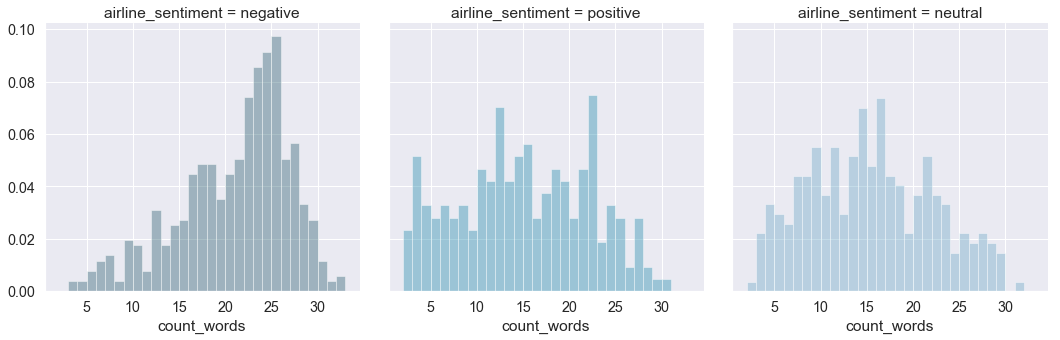

In [15]:
show_dist(df_eda, 'count_words')

Descriptive stats for count_mentions
------------------------------------
                   count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                    
negative           514.0  1.103113  0.346340  1.0  1.0  1.0  1.0  4.0
neutral            272.0  1.253676  0.605925  1.0  1.0  1.0  1.0  5.0
positive           214.0  1.158879  0.467729  1.0  1.0  1.0  1.0  5.0


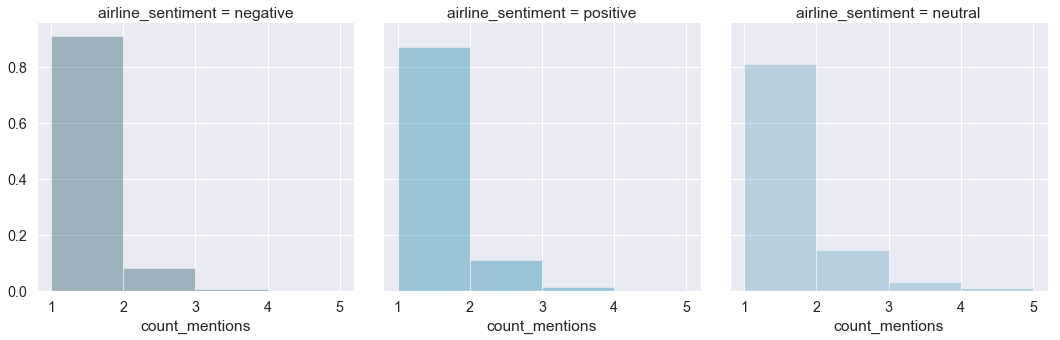

In [16]:
show_dist(df_eda, 'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
                   count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                    
negative           514.0  0.227626  0.572889  0.0  0.0  0.0  0.0  5.0
neutral            272.0  0.261029  0.719950  0.0  0.0  0.0  0.0  4.0
positive           214.0  0.378505  0.873021  0.0  0.0  0.0  0.0  7.0


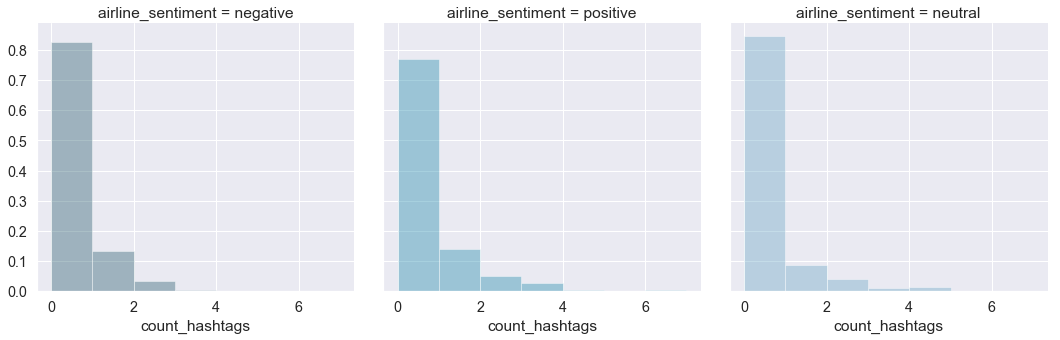

In [17]:
show_dist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
                   count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                     
negative           514.0  0.461089  1.033288  0.0  0.0  0.0  1.0  14.0
neutral            272.0  0.459559  0.831917  0.0  0.0  0.0  1.0  4.0 
positive           214.0  0.415888  0.861231  0.0  0.0  0.0  1.0  7.0 


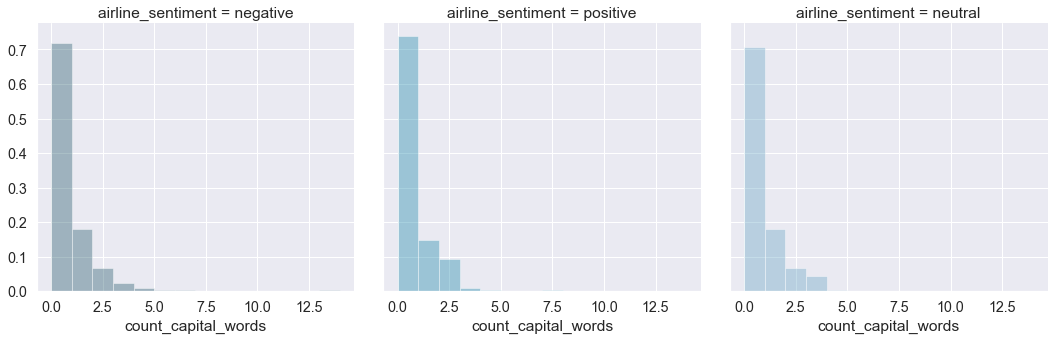

In [18]:
show_dist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
                   count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                    
negative           514.0  0.636187  0.954079  0.0  0.0  0.0  1.0  7.0
neutral            272.0  0.617647  0.824521  0.0  0.0  0.0  1.0  6.0
positive           214.0  0.925234  1.283342  0.0  0.0  1.0  1.0  8.0


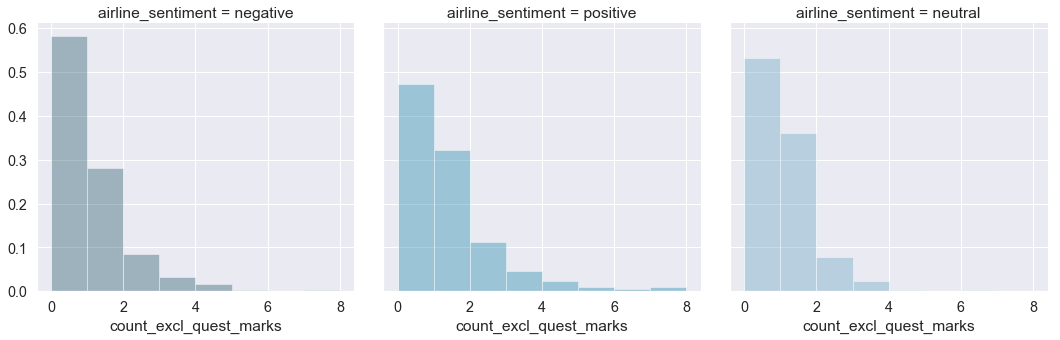

In [19]:
show_dist(df_eda, 'count_excl_quest_marks')

Descriptive stats for count_urls
--------------------------------
                   count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                    
negative           514.0  0.052529  0.231874  0.0  0.0  0.0  0.0  2.0
neutral            272.0  0.216912  0.455399  0.0  0.0  0.0  0.0  2.0
positive           214.0  0.144860  0.365851  0.0  0.0  0.0  0.0  2.0


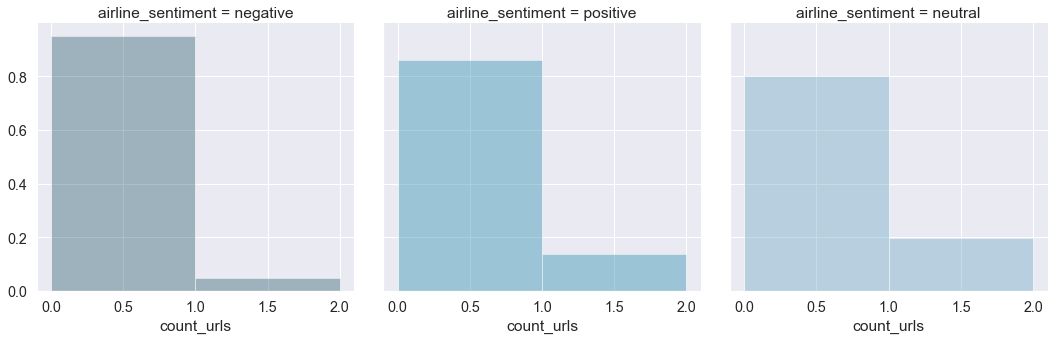

In [20]:
show_dist(df_eda, 'count_urls')

Descriptive stats for count_emojis
----------------------------------
                   count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                    
negative           514.0  0.029183  0.209716  0.0  0.0  0.0  0.0  3.0
neutral            272.0  0.143382  0.669328  0.0  0.0  0.0  0.0  5.0
positive           214.0  0.135514  0.479975  0.0  0.0  0.0  0.0  3.0


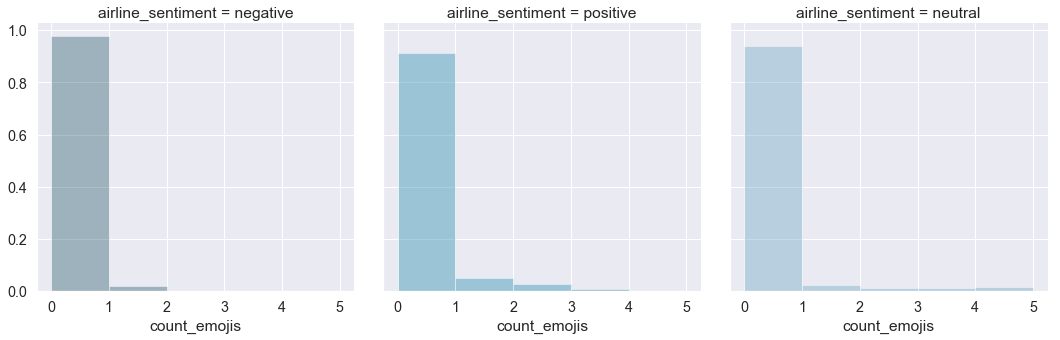

In [21]:
show_dist(df_eda, 'count_emojis')

**CONCLUSIONS: **
* **The number of words** used in the tweets is rater low. Maximum number of words is 36 and there are even tweets with only 2 words. So we'll have to be careful during data cleaning not to remove too many words. On the other hand, the text processing will be faster. Negative tweets contain more words than neutral or positive tweets.
* All tweets have at least one **mention**. Probably this is the result of extracting the tweets based on mentions in the Twitter data. There seems to be no difference in number of mentions with regard to the sentiment.
* Most of the tweets do not contain **hash tags**. So probably this variable will not be retained during model training. Again, no difference in number of hash tags with regard to the sentiment.
* Most of the tweets do not contain **capitalized words** and we do not see a difference in distribution between the sentiments.
* The positive tweets seem to be using a bit more **exclamation or question marks**.
* Most tweets do not contain a **URL**. 
* Most tweets do not use **emojis**.

# Text Cleaning

In [22]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [23]:
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(5)

13     fli fabul seduct sky take stress away travel                                
724    nope told us time go home sleep airport even though assur us would get room 
396    get help support ticket day incid thank                                     
758    flew unit au austin bergstrom cancun intl best flight ever not big not small
880    like continent chicken feat fair                                            
Name: text, dtype: object

Empty twit can cause an error for the Word2Vec algorithm, replace it by 'no text'

In [4]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

NameError: name 'sr_clean' is not defined

## Most frequent words

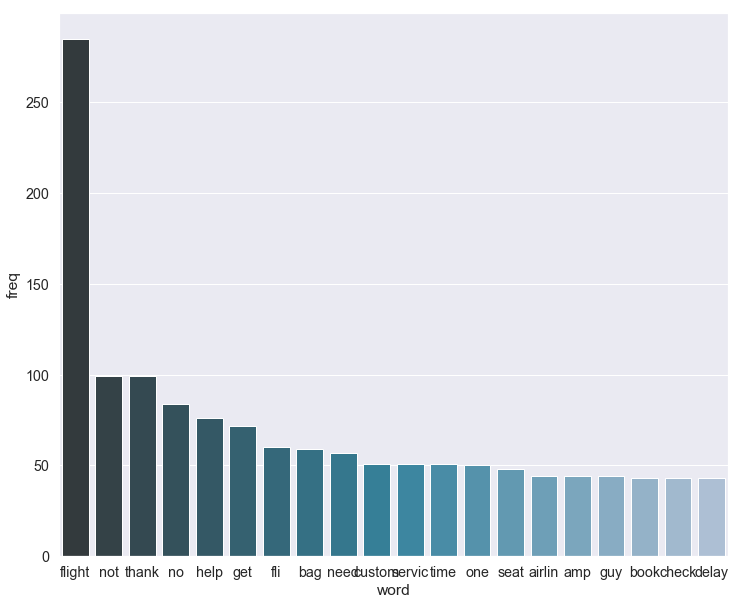

In [25]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

# Creating test data

In [26]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'airline_sentiment',
 'clean_text']

To specifically select columns: 

In [27]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment, test_size=0.1, random_state=37)

## Hyperparameter tuning and cross-validation

### Evaluation metrics
By default GridSearchCV uses the default scorer to compute the *best_score_*. For both the MultiNomialNb and LogisticRegression this default scoring metric is the accuracy. 

In our function *grid_vect* we additionally generate the *classification_report* on the test data. This provides some interesting metrics **per target class**, which might be more appropriate here. These metrics are the **precision, recal and F1 score.**

* **Precision: ** Of all rows we predicted to be a certain class, how many did we correctly predict?
* **Recall: ** Of all rows of a certain class, how many did we correctly predict?
* **F1 score: ** Harmonic mean of Precision and Recall.

Precision and Recall can be calculated with the elements of the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

$$Precision = {TP \over TP + FP}$$


$$Recall = {TP \over TP + FN}$$


$$F1 = {2*{Precision*Recall \over Precision + Recall}}$$

In [29]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

### Parameter grids for GridSearchCV

In [30]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

## Classifiers
Here we will compare the performance of a MultinomailNB and LogisticRegression.

In [31]:
mnb = MultinomialNB()
logreg = LogisticRegression()

## CountVectorizer
Sklearn's **CountVectorizer** takes all words in all tweets, assigns an ID and counts the frequency of the word per tweet. This *bag of words* can then be used as input for a classifier. It is what is called a **sparse** data set, meaning that each record will have many zeroes for the words not occurring in the tweet.

In [32]:
countvect = CountVectorizer()

In [33]:
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
#joblib.dump(best_mnb_countvect, '../output/best_mnb_countvect.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s


done in 22.839s

Best CV score: 0.669
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.690


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.73      0.90      0.81        49
     neutral       0.47      0.41      0.44        22
    positive       0.76      0.55      0.64        29

   micro avg       0.69      0.69      0.69       100
   macro avg       0.66      0.62      0.63       100
weighted avg       0.68      0.69      0.68       100



[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   22.7s finished


In [34]:
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
#joblib.dump(best_logreg_countvect, '../output/best_logreg_countvect.pkl')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   33.2s finished


done in 33.343s

Best CV score: 0.694
Best parameters set:
	clf__C: 0.5
	clf__penalty: 'l1'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.610


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.70      0.78      0.74        49
     neutral       0.32      0.45      0.38        22
    positive       0.87      0.45      0.59        29

   micro avg       0.61      0.61      0.61       100
   macro avg       0.63      0.56      0.57       100
weighted avg       0.67      0.61      0.62       100



## TF-IDF
One issue with CountVectorizer is that there might be words that occur frequently in observations of the target classes. These words do not have discriminatory information and can be removed. **TF-IDF (term frequency - inverse document frequency)** can be used to downweight these frequent words.

$$tfidf(t,d) = tf(t,d)*idf(t,d)$$

where tf(t,d) is the number of times term *t* occurs in document *d*. The inverse document frequency can be computed as follows:

$$idf(t,d) = log{n_d \over 1 + df(d,t)}$$

* $n_d$ is the number of documents
* df(d,t) is the number of documents that contain term *t*

We see that words that occur in many documents will have a low idf. By adding 1 to the denominator, we avoid having an idf equal to zero for words that occur in all documents.

In [35]:
tfidfvect = TfidfVectorizer()

In [36]:
# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
#joblib.dump(best_mnb_tfidf, '../output/best_mnb_tfidf.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   15.6s finished


done in 15.828s

Best CV score: 0.649
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.650


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.67      0.90      0.77        49
     neutral       0.47      0.41      0.44        22
    positive       0.80      0.41      0.55        29

   micro avg       0.65      0.65      0.65       100
   macro avg       0.65      0.57      0.58       100
weighted avg       0.66      0.65      0.63       100



In [37]:
# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
#joblib.dump(best_logreg_tfidf, '../output/best_logreg_tfidf.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.3s


done in 32.939s

Best CV score: 0.690
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l1'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.600


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.66      0.78      0.71        49
     neutral       0.32      0.41      0.36        22
    positive       0.93      0.45      0.60        29

   micro avg       0.60      0.60      0.60       100
   macro avg       0.64      0.54      0.56       100
weighted avg       0.66      0.60      0.60       100



[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.7s finished


## Conclusion
* Both classifiers achieve the best results when using the features of the CountVectorizer
* Overall, Logistic Regression outperforms the Multinomial Naive Bayes classifier
* The best performance on the test set comes from the LogisticRegression with features from CountVectorizer. 

Best parameters:
* C value of 1
* L2 regularization
* max_df: 0.5 or maximum document frequency of 50%.
* min_df: 1 or the words need to appear in at least 2 tweets
* ngram_range: (1, 2), both single words as bi-grams are used

Evaluation metrics:
* A **test accuracy** of 81,3%, which is better than what we would achieve by setting the prediction for all observations to the majority class (*negative* which would give 63% accuracy).
* The **Precision** is rather high for all three classes. For instance, of all cases that we predict as negative, 80% is indeed negative.
* The **Recall** for the neutral class is low. Of all neutral cases in our test data, we only predict 48% as being neutral.

# Apply the best model on new tweets

In [44]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                         , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
                                              , ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
                       , n_jobs=-1)

pipeline = Pipeline([
    ('features', features)
    , ('clf', LogisticRegression(C=1.0, penalty='l2'))
])

best_model = pipeline.fit(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment)

## New positive tweets

In [45]:
new_positive_tweets = pd.Series(["Thank you @VirginAmerica for you amazing customer support team on Tuesday 11/28 at @EWRairport and returning my lost bag in less than 24h! #efficiencyiskey #virginamerica"
                      ,"Love flying with you guys ask these years.  Sad that this will be the last trip 😂   @VirginAmerica  #LuxuryTravel"
                      ,"Wow @VirginAmerica main cabin select is the way to fly!! This plane is nice and clean & I have tons of legroom! Wahoo! NYC bound! ✈️"])

df_counts_pos = tc.transform(new_positive_tweets)
df_clean_pos = ct.transform(new_positive_tweets)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos

best_model.predict(df_model_pos).tolist()

['positive', 'positive', 'positive']

## New negative tweets

In [46]:
new_negative_tweets = pd.Series(["@VirginAmerica shocked my initially with the service, but then went on to shock me further with no response to what my complaint was. #unacceptable @Delta @richardbranson"
                      ,"@VirginAmerica this morning I was forced to repack a suitcase w a medical device because it was barely overweight - wasn't even given an option to pay extra. My spouses suitcase then burst at the seam with the added device and had to be taped shut. Awful experience so far!"
                      ,"Board airplane home. Computer issue. Get off plane, traverse airport to gate on opp side. Get on new plane hour later. Plane too heavy. 8 volunteers get off plane. Ohhh the adventure of travel ✈️ @VirginAmerica"])

df_counts_neg = tc.transform(new_negative_tweets)
df_clean_neg = ct.transform(new_negative_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg

best_model.predict(df_model_neg).tolist()

['negative', 'negative', 'negative']